<h1><center>CSCI - 6409 - The Process of Data Science - Summer 2022</h1></center>

<h1><center>Predicting expected social media usage of users</h1></center>

<h3><center>Group 4</h3></center>
<center>
<table>
  <th>Name</th>
  <th>Banner ID</th>
  <tr>
  <td> Jaimi Sheta </td>
  <td> B00886563 </td>
  </tr>
  <tr>
  <td> Jay Bhagvanbhai Sonani </td>
  <td> B00891984 </td>
  </tr>
  <tr>
  <td> Mitul Pravinbhai Malani </td>
  <td> B00869519 </td>
  </tr>
  <tr>
  <td> Prit Ajaykumar Sorathiya </td>
  <td> B00890175 </td>
  </tr>
  <tr>
  <td> Prit Thakkar </td>
  <td> B00890731 </td>
  </tr>
  
</table>
</center>

In [ ]:
# reference: https://github.com/wkentaro/gdown
# Downloading dataset from the drive in this environment
!gdown --id 1EwhSH8UdWESEhXS2xutl0G_Yb81MIMhC
!unzip dataset.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1EwhSH8UdWESEhXS2xutl0G_Yb81MIMhC
To: /content/dataset.zip
100% 167M/167M [00:02<00:00, 63.2MB/s]
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
  inflating: dataset/customers.csv   
  inflating: __MACOSX/dataset/._customers.csv  
  inflating: dataset/pings.csv       
  inflating: __MACOSX/dataset/._pings.csv  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
  inflating: dataset/test.csv        
  inflating: __MACOSX/dataset/._test.csv  


In [ ]:
# importing necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode as stat_mode
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import sklearn
from mlxtend.plotting import plot_learning_curves
from lightgbm import (LGBMRegressor, early_stopping)
from scipy import stats

In [ ]:
# dataset reference: https://www.kaggle.com/datasets/bhuvanchennoju/mobile-usage-time-prediction
# Loading dataset
data_customers = pd.read_csv("/content/dataset/customers.csv")
data_pings = pd.read_csv("/content/dataset/pings.csv")
data_test = pd.read_csv("/content/dataset/test.csv")

## Data Exploration and Preprocessing<a id='top'></a>

---




### Problem Statement and Data Overview
#### ***Problem Statement***
In this technological age, we are moving toward online communication, which has resulted in an increase in people's screen time all over the world, and we want to study, analyze, and predict the amount spent by a specific customer based on factors such as age, number of children, and smartphone device, to name a few.
#### ***Data Overview***
Data: USERS ACTIVE TIME PREDICTION

The provided dataset consists of three files, the outline information is as per below.<br/>
1.**customers.csv** - Contains customer's personal information. <br>
-   id - the unique identifier for a customer
*   gender - gender of a customer, possible values - Male and Female
*   number_of_kids - the total number of kids a customer has as of collection of data
*   smartphone_device - the brand of smartphone used by a customer
*   internet_provider - customer's broadband service
*   application_name - the name of the application, a customer was using during collection data.
2.**pings.csv** - Contains the server pings for a customer
*   id - the customer id for whom the ping is logged
*   timestamp - the UNIX timestamp when the event is logged

3.**test.csv** - Contains the server pings for a customer
*   id - the customer id for whom the ping is logged
*   date - the date for which we have to predict the number of hours
*   onlinehours - the total number of hours spent on social media apps




In [ ]:
# Getting an overview of the dataset
print('Customer Data')
display(data_customers.head(5))
print('\nServer pings data')
display(data_pings.head(5))

Customer Data


,Unnamed: 0,id,gender,age,number_of_kids,smartphone_device,internet_provider,application_name
0,0,979863,MALE,26,2,Google,AT&T,TikTok
1,1,780123,MALE,60,2,Apple,Rogers,Whatsapp
2,2,614848,MALE,45,4,TCL,Jio Fiber,TikTok
3,3,775046,MALE,62,3,Nokia,Rogers,Instagram
4,4,991601,MALE,23,0,Apple,Gtpl,Facebook



Server pings data


,id,timestamp
0,899313,1496278800
1,373017,1496278800
2,798984,1496278800
3,245966,1496278800
4,689783,1496278800


In [ ]:
data_customers.dtypes 

Unnamed: 0            int64
id                    int64
gender               object
age                   int64
number_of_kids        int64
smartphone_device    object
internet_provider    object
application_name     object
dtype: object

### **Data Quality Report**

---


As the dataset is a mix bag of continuous and categorical data, we have to analyze both separately. We will use max_values, min_values for continuous data and mode for categorical data, along with computing the missing data, data types and unique values.

For the continuous side of things, we find that there are no missing values in the features age and number of kids. The age ranges from 18 to 75, which seems normal in terms of social media app usage and the number of children range from no children to 4 children.

On the categorical side of things, we have gender, smartphone_device, internet_provider and application_name. The majority gender in the dataset is Male, the preffered mobile brand among the sample is Apple and the internet_provider is AT&T with TikTok leading among the app usage. One thing to notice here are the missing values in the internet provider field, which wil be covered in the Data Issues part of this notebook.


In [ ]:
# Building a data quality report for continuous features
def continuous_data_quality_report(data):
  data_types = pd.DataFrame(data.dtypes, columns=['Data Type'])
  missing_data = pd.DataFrame(data.isnull().sum(), columns=['Missing Values'])
  unique_values = pd.DataFrame(columns=['Unique Values'])
  max_values = pd.DataFrame(columns=['Maximum Values'])
  min_values = pd.DataFrame(columns=['Minimum Values'])
  # Iterating through all values 
  for entry in list(data.columns.values):
      unique_values.loc[entry] = [data[entry].nunique()]
      max_values.loc[entry] = [data[entry].max()]
      min_values.loc[entry] = [data[entry].min()]
  # Combining Data
  report = data_types.join(missing_data).join(unique_values).join(max_values).join(min_values)
  return report

In [ ]:
# Building a data quality report for categorical features
def categorical_data_quality_report(data):
  data_types = pd.DataFrame(data.dtypes, columns=['Data Type'])
  missing_data = pd.DataFrame(data.isnull().sum(), columns=['Missing Values'])
  unique_values = pd.DataFrame(columns=['Unique Values'])
  mode = pd.DataFrame(columns=['Mode'])
  # Iterating through all values 
  for entry in list(data.columns.values):
      unique_values.loc[entry] = [data[entry].nunique()]
      mode.loc[entry] = [stat_mode(data[entry])]
  # Combining Data
  report = data_types.join(missing_data).join(unique_values).join(mode);
  return report

In [ ]:
data_customers_continuous = data_customers[['age','number_of_kids']];
data_customers_categorical = data_customers[['gender','smartphone_device','internet_provider','application_name']];

continuous_report = continuous_data_quality_report(data_customers_continuous);
categorical_report = categorical_data_quality_report(data_customers_categorical);

print('Data Quality Report for Continuous Features');
print('Continuous Feature Length: ',len(data_customers_continuous));
display(continuous_report);

print('\nData Quality Report for Categorical Features');
print('Categorical Feature Length: ',len(data_customers_categorical));
display(categorical_report)

Data Quality Report for Continuous Features
Continuous Feature Length:  2500


,Data Type,Missing Values,Unique Values,Maximum Values,Minimum Values
age,int64,0,58,75,18
number_of_kids,int64,0,5,4,0



Data Quality Report for Categorical Features
Categorical Feature Length:  2500


,Data Type,Missing Values,Unique Values,Mode
gender,object,0,2,MALE
smartphone_device,object,0,12,Apple
internet_provider,object,127,11,Bell
application_name,object,0,6,TikTok


### **Data Quality Issues**

---



1. The dataset contains a duplicate index column called 'Unnamed: 0', we have to remove that before processing. 
2. We have customer id in the customers dataframe and in the pings dataframe, which is irrelevant but, we cannot remove it until we perform a groupby based on customer_id for model training.
3. Gender is a categorical ('MALE','FEMALE'), we need to do one hot encoding.
4. There are some missing values in the internet_provider field and we will replace such columns by mode.
5. In the pings the dataframe, we have timestamp which cannot be used for model training as , we need to convert it to more interpretable fields for model training.

In [ ]:
data_customers.columns
df_customers_process = data_customers.copy(deep=True)

In [ ]:
# Dropping the irrelevant Unnamed: 0 column from the dataset
df_customers_process.drop(labels=['Unnamed: 0'],inplace=True,axis=1)
df_customers_process.columns

Index(['id', 'gender', 'age', 'number_of_kids', 'smartphone_device',
       'internet_provider', 'application_name'],
      dtype='object')

In [ ]:
# Performing one hot encoding for age
df_customers_process['gender'] = df_customers_process['gender'].replace(to_replace=['MALE', 'FEMALE'], value=[1,0])
display(df_customers_process.head(5))

,id,gender,age,number_of_kids,smartphone_device,internet_provider,application_name
0,979863,1,26,2,Google,AT&T,TikTok
1,780123,1,60,2,Apple,Rogers,Whatsapp
2,614848,1,45,4,TCL,Jio Fiber,TikTok
3,775046,1,62,3,Nokia,Rogers,Instagram
4,991601,1,23,0,Apple,Gtpl,Facebook


In [ ]:
# Identifying Missing Values
# resource: https://stackoverflow.com/questions/30447083/python-pandas-return-only-those-rows-which-have-missing-values 

null_records = df_customers_process[df_customers_process.isnull().any(axis=1)]
print("Missing values:", len(null_records))
display(null_records.head())

Missing values: 127


,id,gender,age,number_of_kids,smartphone_device,internet_provider,application_name
57,832945,1,18,0,Motorola,NaN,Facebook
67,199192,1,31,4,Apple,NaN,Instagram
85,982846,1,31,4,Motorola,NaN,Youtube
86,831323,0,47,0,Xiaomi,NaN,Youtube
111,346754,0,22,1,OnePlus,NaN,Facebook


In [ ]:
# Replacing missing values with mode
df_customers_process['internet_provider'].fillna(df_customers_process['internet_provider'].mode()[0], inplace=True)
null_records = df_customers_process[df_customers_process.isnull().any(axis=1)]
print("Missing values:", len(null_records))

Missing values: 0


#### Processing of UNIX timestamp to match with test data.
As we have 50M entries in the pings dataset, due to the lack of memory resouces and to avoid frequent crashes, we have decided to go with 2000000 entries of pings data.

In [ ]:
df_pings_process = data_pings.copy(deep=True)

In [ ]:
# Sampling Pings data due to memory limitations as it contains over 50M records
df_pings_process = df_pings_process.sample(n=2000000)

In [ ]:
# Timestamp in ascending order
df_pings_process.sort_values("timestamp", inplace=True)

In [ ]:
# As it can be seen in the ping dataset, we need to convert timestamp to date-time and extract month, year to gain more insights
df_pings_process['datetime'] = [datetime.fromtimestamp(x) for x in df_pings_process['timestamp']]
df_pings_process['date'] = pd.DatetimeIndex(df_pings_process['datetime']).date  

#### Sorting timestamp and performing operations to compute number of hours
As we have customer_id, date and number of hours spent in the test data, we have sorted the dataframe on the basis of timestamp, then performed a group by on id and date and computed the timestamp difference.

As a result, we now have id, date and customer_active_hours which matches the features on our test dataset.

In [ ]:
# reference: https://stackoverflow.com/questions/70179295/how-to-calculate-the-id-time-difference
df_pings_process['customer_active_hours'] = (df_pings_process.groupby(by=['id','date'])['timestamp'].diff())/(60*60)
df_pings_process['customer_active_hours']  =  df_pings_process['customer_active_hours'].apply(lambda x: x if x< (2/60) else (2/60))
df_pings_process.fillna(0,inplace = True)
df_pings_process = (df_pings_process.groupby(by = ['id','date'])['customer_active_hours'].sum()).reset_index()
df_pings_process['customer_active_hours'] = round(df_pings_process['customer_active_hours'],1)

In [ ]:
df_pings_process.tail(10)

,id,date,customer_active_hours
41612,998229,2017-06-13,1.6
41613,998229,2017-06-14,2.1
41614,998229,2017-06-15,1.7
41615,998229,2017-06-16,1.9
41616,998229,2017-06-17,1.4
41617,998229,2017-06-18,1.5
41618,998229,2017-06-19,2.2
41619,998229,2017-06-20,0.1
41620,998229,2017-06-21,2.6
41621,998229,2017-06-22,0.2


In [ ]:
# converting datetime to day, month and year
df_pings_process['day'] = pd.DatetimeIndex(df_pings_process['date']).day
df_pings_process['month'] = pd.DatetimeIndex(df_pings_process['date']).month
df_pings_process['year'] = pd.DatetimeIndex(df_pings_process['date']).year

In [ ]:
df_pings_process.head()
model_df = df_pings_process.copy(deep=True)

## Data Analysis and Visualization

---



Module Outline

1. Plot a correlation heatmap to check the correlation between all the features. 
2. Plot histograms for continuous features, bar plot for categorical features and scatter plots according to the needs.

Text(0.5, 1.0, 'Heatmap')

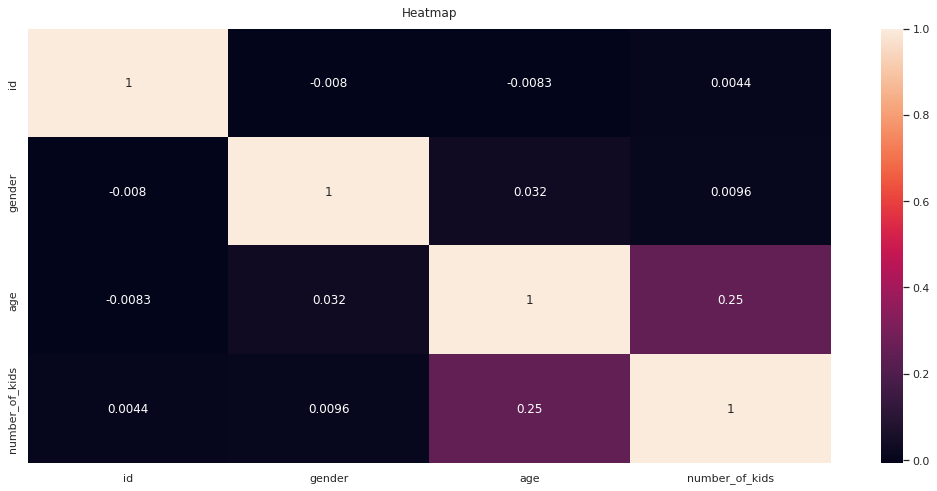

In [ ]:
# reference: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
# plot heatmap to find correlation betweens the data
plt.subplots(figsize=(18,8))
heatmap = sns.heatmap(df_customers_process.corr(), annot=True)
heatmap.set_title('Heatmap', pad=12)

#### Customers by Age
As we are dealing with online hours spent, it is expected that we get a right-skewed histogram as majority of active users will be between the age group of 20-50.

Text(0.5, 1.0, '# of Customers by their age')

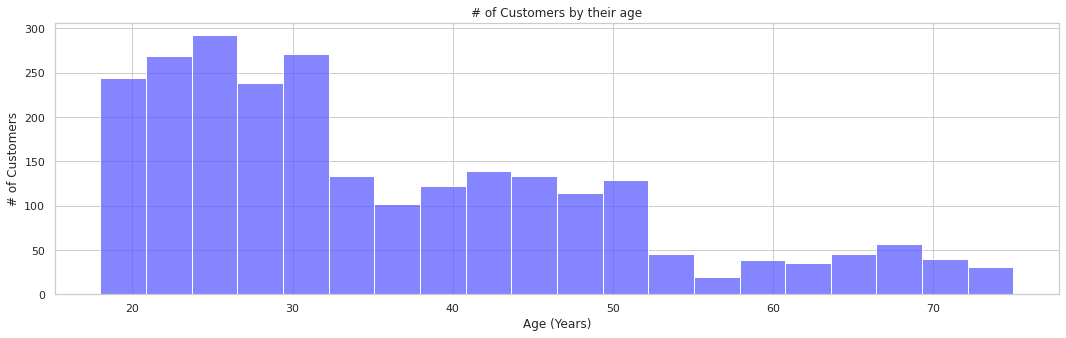

In [ ]:
# Customers by age group
plt.subplots(figsize=(18,5))
ax = sns.histplot(df_customers_process['age'], bins=20, color = '#5C5CFF')
ax.set_ylabel('# of Customers')
ax.set_xlabel('Age (Years)')
ax.set_title('# of Customers by their age')

#### Customers by Gender
From the dataset, we find majority of males than females in the current sample.

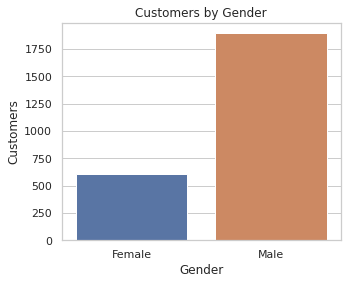

In [ ]:
# Customers based on gender
plt.figure(figsize=(5,4))
ax = sns.countplot(x='gender', data=df_customers_process)
ax.set(xlabel='Gender', ylabel='Customers',title="Customers by Gender")
ax = ax.set_xticklabels(["Female","Male"])

#### Customers by Smartphone Device
From the barplot, we find that people are more into using Apple devices, followed by Samsung, OnePlus and Google.

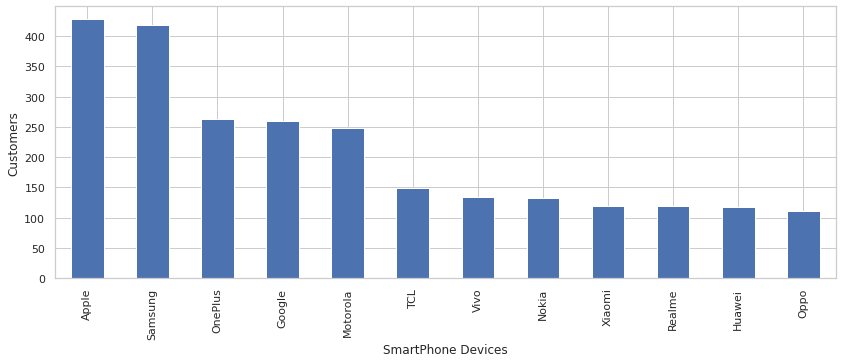

In [ ]:
# Phone used by customers
plt.subplots(figsize=(14,5))
df_customers_process['smartphone_device'].value_counts().plot.bar(xlabel='SmartPhone Devices', ylabel='Customers')

#### Customers by Internet Service Provider
From the barplot, we find that people are more into using Bell followed by Rogers, Verizon, AT&T.

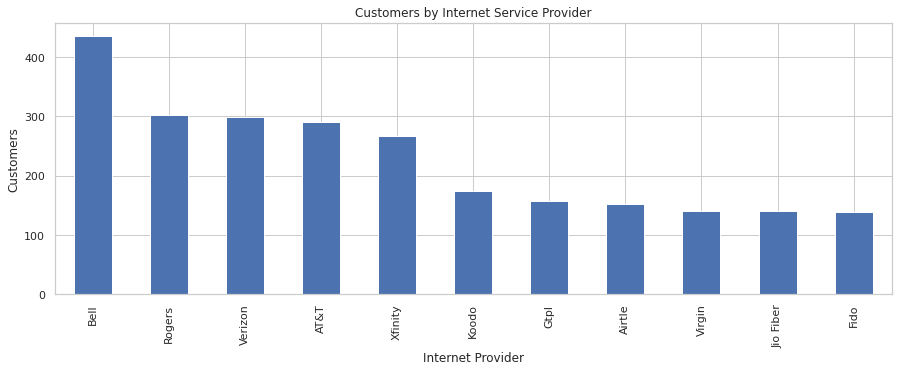

In [ ]:
# Internet service providers opted by customers
plt.subplots(figsize=(15,5))
df_customers_process['internet_provider'].value_counts().plot.bar(xlabel='Internet Provider', ylabel='Customers', title="Customers by Internet Service Provider")

#### Application Usage
From the dataset, TikTok is the widely used application in the sample

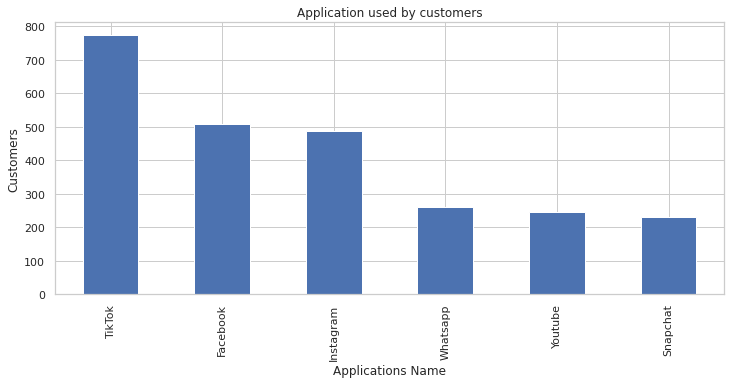

In [ ]:
# Application used by customers
plt.subplots(figsize=(12,5))
df_customers_process['application_name'].value_counts().plot.bar(xlabel='Applications Name',
                                                                 ylabel='Customers', title="Application used by customers")

#### Merging dataset for further visualization
As the main target to predict here is the number of hours, and it is in a different dataframe, we will have to merge the customers data and the pings data to make the further visualization.

We will merge the dataset grouping it on the customer id, join type will be left as we dont want to lose any customer data.

In [ ]:
# Merging dataset for visualization
merged_df = df_customers_process.merge(df_pings_process,how='left', on='id')
df_pings_process

,id,date,customer_active_hours,day,month,year
0,111556,2017-06-01,0.3,1,6,2017
1,111556,2017-06-02,0.5,2,6,2017
2,111556,2017-06-05,0.8,5,6,2017
3,111556,2017-06-06,1.0,6,6,2017
4,111556,2017-06-07,0.7,7,6,2017
...,...,...,...,...,...,...
41617,998229,2017-06-18,1.5,18,6,2017
41618,998229,2017-06-19,2.2,19,6,2017
41619,998229,2017-06-20,0.1,20,6,2017
41620,998229,2017-06-21,2.6,21,6,2017


Text(0.5, 1.0, 'Day vs Hour Spent')

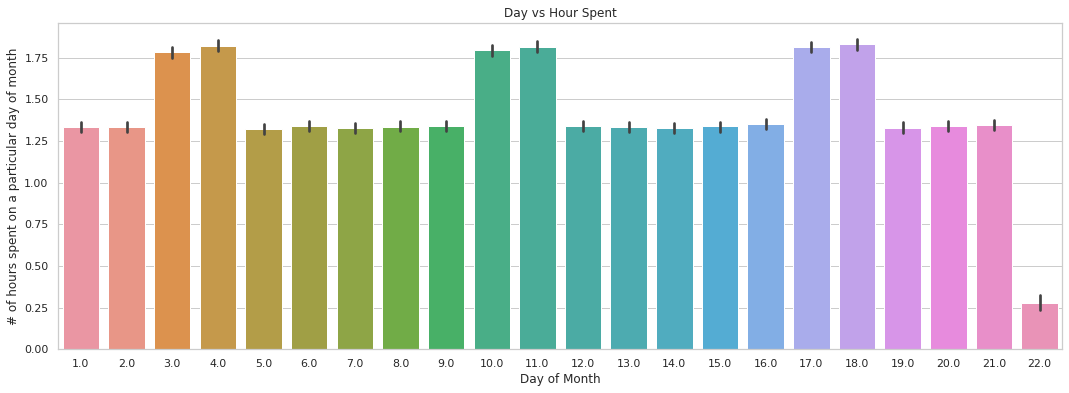

In [ ]:
plt.subplots(figsize=(18,6))
ax = sns.barplot(x='day', y="customer_active_hours", data=merged_df)
ax.set_ylabel('# of hours spent on a particular day of month')
ax.set_xlabel('Day of Month')
ax.set_title('Day vs Hour Spent')

Text(0.5, 1.0, 'number of hours')

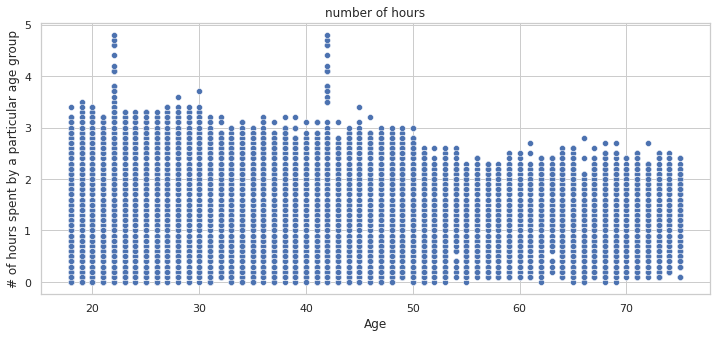

In [ ]:
plt.subplots(figsize=(12,5))
ax = sns.scatterplot(x='age',y="customer_active_hours",data=merged_df)
ax.set_ylabel('# of hours spent by a particular age group')
ax.set_xlabel('Age')
ax.set_title('number of hours')

In [ ]:
merged_df.head()

,id,gender,age,number_of_kids,smartphone_device,internet_provider,application_name,date,customer_active_hours,day,month,year
0,979863,1,26,2,Google,AT&T,TikTok,2017-06-01,2.6,1.0,6.0,2017.0
1,979863,1,26,2,Google,AT&T,TikTok,2017-06-02,3.1,2.0,6.0,2017.0
2,979863,1,26,2,Google,AT&T,TikTok,2017-06-03,2.8,3.0,6.0,2017.0
3,979863,1,26,2,Google,AT&T,TikTok,2017-06-04,2.2,4.0,6.0,2017.0
4,979863,1,26,2,Google,AT&T,TikTok,2017-06-06,2.8,6.0,6.0,2017.0


Text(0.5, 20.200000000000003, 'smartphone device')

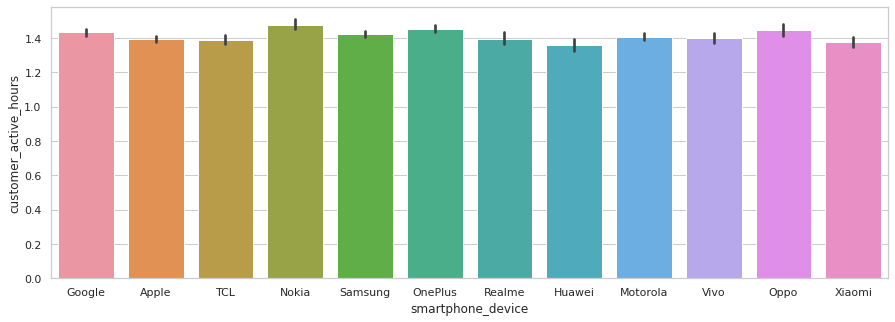

In [ ]:
plt.subplots(figsize=(15,5))
sns.barplot(x='smartphone_device', y="customer_active_hours", data=merged_df)
ax.set_ylabel('# of hours spent by a smartphone provider')
ax.set_xlabel('smartphone device')

Text(0.5, 1.0, 'number of hours')

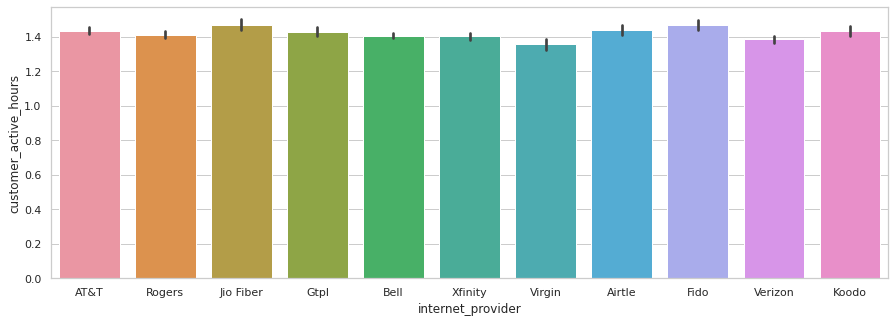

In [ ]:
plt.subplots(figsize=(15,5))
sns.barplot(x='internet_provider', y="customer_active_hours", data=merged_df)
ax.set_ylabel('# of hours spent by a internet provider')
ax.set_xlabel('internet provider')
ax.set_title('number of hours')

Text(0.5, 1.0, 'number of hours')

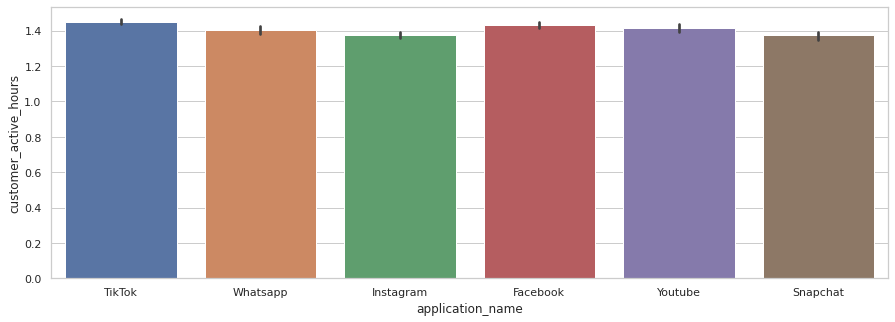

In [ ]:
plt.subplots(figsize=(15,5))
sns.barplot(x='application_name', y="customer_active_hours", data=merged_df)
ax.set_ylabel('# of hours spent by application')
ax.set_xlabel('application name')
ax.set_title('number of hours')

## Data Modeling, Results and Evaluation

---



##### Create dataset for modeling

We have merged customer processed dataset with the model dataset, so combine dataset contains all the important features which will be required to generate, train, and evaluate the model.

In [ ]:
temp_model_df = pd.merge(left = df_customers_process, right = model_df, on = 'id', how = 'outer')
temp_model_df.dropna(inplace = True)

In [ ]:
temp_model_df.head()

,id,gender,age,number_of_kids,smartphone_device,internet_provider,application_name,date,customer_active_hours,day,month,year
0,979863,1,26,2,Google,AT&T,TikTok,2017-06-01,2.6,1.0,6.0,2017.0
1,979863,1,26,2,Google,AT&T,TikTok,2017-06-02,3.1,2.0,6.0,2017.0
2,979863,1,26,2,Google,AT&T,TikTok,2017-06-03,2.8,3.0,6.0,2017.0
3,979863,1,26,2,Google,AT&T,TikTok,2017-06-04,2.2,4.0,6.0,2017.0
4,979863,1,26,2,Google,AT&T,TikTok,2017-06-06,2.8,6.0,6.0,2017.0


#### Preprocessing the dataset

Dataset contains some of the attributes with the string data, which makes impossible to find the significance from those features. So, we have performed encoding, to convert values of [smartphone_device, internet_provider, application_name] into numerical data. 

In [ ]:
columns = ['smartphone_device', 'internet_provider', 'application_name']

for column in columns: 
  temp_model_df[column] = temp_model_df[column].replace(to_replace=temp_model_df[column].unique(), value= list(range(0, len(temp_model_df[column].unique()))))


In [ ]:
temp_model_df.head()

,id,gender,age,number_of_kids,smartphone_device,internet_provider,application_name,date,customer_active_hours,day,month,year
0,979863,1,26,2,0,0,0,2017-06-01,2.6,1.0,6.0,2017.0
1,979863,1,26,2,0,0,0,2017-06-02,3.1,2.0,6.0,2017.0
2,979863,1,26,2,0,0,0,2017-06-03,2.8,3.0,6.0,2017.0
3,979863,1,26,2,0,0,0,2017-06-04,2.2,4.0,6.0,2017.0
4,979863,1,26,2,0,0,0,2017-06-06,2.8,6.0,6.0,2017.0


#### The task we are solving is (e.g., supervised x unsupervised, classification x regression x clustering or similarity matching x, etc).

As we have considered customer_active_hours as a target variable and based on analysis of given dataset, we have decided to use **supervised** machine learning algorithms. Supervised machine learning learns from the labeled training data and predict outcomes for unforeseen data. So, we believed that it fits more with given problems. 

Also, we have decided to use **regression** technique to investigate the relationship between independent variables and a dependent variable. It’s used as a machine learning model or algorithm to predict continuous outcomes. Therefore, as we need to predict the customer_active_hours value for unknown data, we believed that regression would be the best suitable technique. 


#### Performed feature selection 

We know that identify the most correlated features is quite important task, that should be done before train any model. So, we have used correlation matrix same as we have done during baseline model to find correlation between features. So, to generate correlation matrix and implement feature selection task, we have used f_regression statistics and SelectKBest which are imported from the sklearn library to implement feature selection task and identify best suitable features. Below figure indicates the 7 selected features which are more correlated with the customer_active_hours feature compared to rest of other features. So, all rest of features has been removed from the dataset.

In [ ]:
# Features
X = temp_model_df.drop(['customer_active_hours', 'date'], axis=1)
# Target
y = temp_model_df['customer_active_hours']

In [ ]:
# testing data
data_test.rename(columns = {'online_hours':'customer_active_hours'}, inplace = True)
data_test.head()

,id,date,customer_active_hours
0,979863,28/06/17,7
1,979863,27/06/17,9
2,979863,26/06/17,9
3,979863,25/06/17,10
4,979863,24/06/17,9


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


List of top 7 most correlated features
('gender', 5678.088956756589)
('age', 644.3075386309596)
('number_of_kids', 197.63675836218695)
('application_name', 23.544084277564206)
('id', 21.414145635192718)
('day', 4.260556765809958)
('internet_provider', 1.8987263012266065)


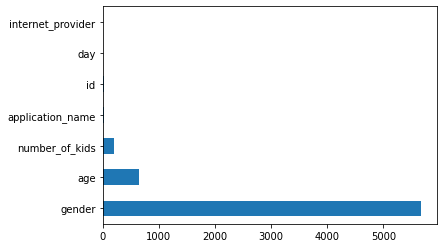

In [ ]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

fs = SelectKBest(score_func=f_regression, k=7)
X_new = fs.fit_transform(X, y)
top_features = sorted(zip(X.columns, fs.scores_), key=lambda x: x[1], reverse=True)

print("List of top 7 most correlated features")
for feature in top_features[:7]: 
  print(feature)

feat_importances = pd.Series(fs.scores_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [ ]:
# considering top 3 features
top_column_names = [x[0] for x in top_features[:7]]
X = X[top_column_names]

#### Evalution Matrix: 

It is necessary to obtain the accuracy on training data, with that it is also important to get a genuine and approximate result on unseen data otherwise Model is of no use. So, to build and deploy a generalized model we require to Evaluate the model on different metrics which helps
us to better optimize the performance, fine-tune it, and obtain a better result.

We have selected [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) for evaluating the model. R2 score is a metric that tells the performance of the model, by mean that how many wells did the model perform. Unlike other metrics, R2 Score compares our model with the baseline model, so it calculates how must regression line is better than mean line.

R2 score values are residing between 0 and 1. Here 1 means the regression line does not make any mistake, however, it is not possible in the real world. While 0 means our model is not better than the model using the mean.

#### Ensuring overfitting problem

In overfiting problem, a model tries to fit the training data entirely and ends up memorizing the data pattens as well as noise. So, these models fail to generalize and perform well in the case of unseen data and ruining the purpose of the model. To avoid this overfiting problem we performed following tasks,

* We make sure that data should be clean and does not contain any missing or  garbage values
* Remove the outliers from the dataset because if the outliers are present in the dataset the model captures the noise in the training data and fails to generalize the model’s learning.
* We have performed encoding to convert values of categorical features into numerical features.
* We make sure that training dataset is enough to train the model accurately.


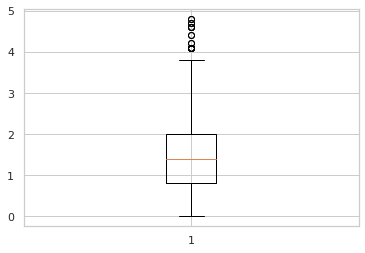

<Figure size 720x504 with 0 Axes>

In [ ]:
# reference: https://www.geeksforgeeks.org/finding-the-outlier-points-from-matplotlib/
# detecting outliers and remove 

sns.set_theme(style="whitegrid")
plt.boxplot(temp_model_df['customer_active_hours'])
fig = plt.figure(figsize =(10, 7))
plt.show()

In [ ]:
#  finding the 1st quartile
q1 = np.quantile(temp_model_df['customer_active_hours'], 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(temp_model_df['customer_active_hours'], 0.75)
med = np.median(temp_model_df['customer_active_hours'])
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(f"IQR = {upper_bound} - {lower_bound} = {iqr}")

IQR = 3.8 - -0.9999999999999998 = 1.2


The total number of outliers are: {24}
The total number of instances before outliers: {41684}
The total number of instances after outliers: {41660}


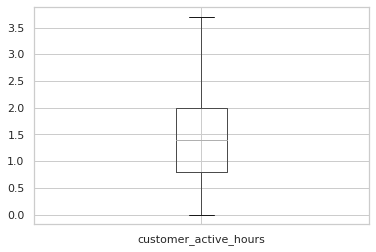

In [ ]:
outliers = temp_model_df[(temp_model_df['customer_active_hours'] <= lower_bound) | (temp_model_df['customer_active_hours'] >= upper_bound)]
print('The total number of outliers are:', {len(outliers)})
print('The total number of instances before outliers:', {len(temp_model_df)})

## remove outliers from the dataset
temo_df = temp_model_df.drop(outliers.index)
temo_df.boxplot('customer_active_hours')
print('The total number of instances after outliers:', {len(temo_df)})

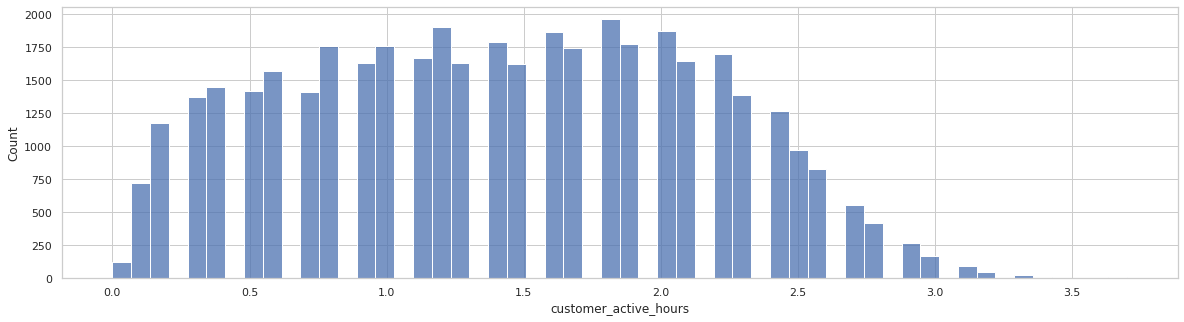

In [ ]:
# histogram visulization for checking whether the data is imblanaced or not
plt.subplots(figsize=(20,5))
sns.histplot(data=temo_df, x="customer_active_hours")

#### Split the dataset into training (40%), validation (30%), and test (30%) splits. 

In [ ]:
# reference: https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c
# Let's say we want to split the data in 40:30:30 for train:valid:test dataset
train_size=0.4

train = temo_df[temo_df['day'] < 22]
test = temo_df[temo_df['day'] == 22]
      
X = train.drop(columns = ['customer_active_hours','date'])
y = train['customer_active_hours'].values

# In the first step we will split the data in training and remaining dataset
X_rem, X_test, y_rem, y_test = train_test_split(X,y, test_size=0.3)

# Now since we want the valid and test size to be equal (30% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_train, X_valid, y_train, y_valid = train_test_split(X_rem,y_rem, train_size=4/7)
 
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)
print("X_valid dataset: ", X_valid.shape)
print("y_valid dataset: ", y_valid.shape)

X_train dataset:  (16633, 10)
y_train dataset:  (16633,)
X_test dataset:  (12475, 10)
y_test dataset:  (12475,)
X_valid dataset:  (12475, 10)
y_valid dataset:  (12475,)


#### Train and evaluate models on test data

##### XGBoost for Regression baseline model

We have used [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) for Regression, which is an efficient implementation of gradient boosting that can be used for regression predictive modeling. Here we are using this model to predict customer_active_hours for unseen data. We have manually tried different hyperparameters and we have found that n_estimator=1000, objective="reg:squarederror", verbosity=0, and random_state=42 parameteres in which model is performing more efficiently. 

In [ ]:
# reference: https://xgboost.readthedocs.io/en/stable/python/python_api.html

xgbmodel = XGBRegressor(n_estimators = 1000, objective ='reg:squarederror', verbosity = 0, random_state=42)
xgbmodel.fit(X_train,y_train)

XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=42,
             verbosity=0)

In [ ]:
y_preds = xgbmodel.predict(X_train)
y_valid_preds = xgbmodel.predict(X_valid)
y_test_preds = xgbmodel.predict(X_test)

In [ ]:
# evalutation 
print("R2 Score using the model on training data: ", r2_score(y_train, y_preds))
print("R2 Score using the model on testing data: ", r2_score(y_test, y_test_preds))
print("R2 Score using the model on validation data: ", r2_score(y_valid, y_valid_preds))

R2 Score using the model on training data:  0.48892894120652053
R2 Score using the model on testing data:  0.4129427654682114
R2 Score using the model on validation data:  0.40629542874253133


#### Plot a visualization of the learning process or the learned information of the model.

A learning curve plots the optimal value of a model's loss function for a training set against this loss function evaluated on a validation data set with same parameters as produced the optimal function. We have plotted two learning curves using two different libraries such as Sklearn, and mlxtend.

In [ ]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# learning curve
train_sizes, train_scores, test_scores = learning_curve(xgbmodel, X_train, y_train, scoring='neg_mean_squared_error')

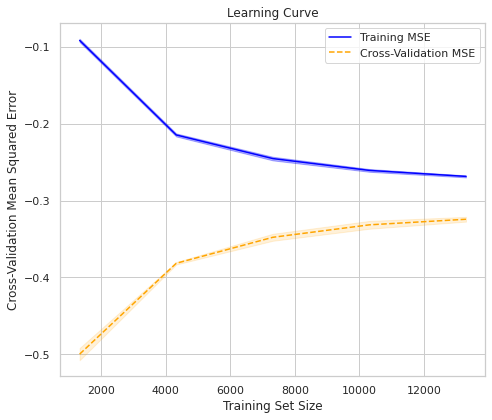

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(7,6))
plt.plot(train_sizes, train_mean, color='blue', label='Training MSE')
plt.plot(train_sizes, test_mean, color='orange', linestyle='--', label='Cross-Validation MSE')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.30, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,alpha=0.15, color='orange')

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Cross-Validation Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

([0.11801383724523773,
  0.19296342281710113,
  0.22079669644777822,
  0.24194832570772754,
  0.25321355689673086,
  0.2625177469455526,
  0.2646168989969612,
  0.2666338512545623,
  0.2701632942480895,
  0.27472293636359973],
 [0.484988331070075,
  0.4031061141291923,
  0.3669381182796027,
  0.35148731300047736,
  0.3426292582832272,
  0.33424385892911546,
  0.3280341378631568,
  0.3220675678410206,
  0.31659817849247474,
  0.31852271428211426])

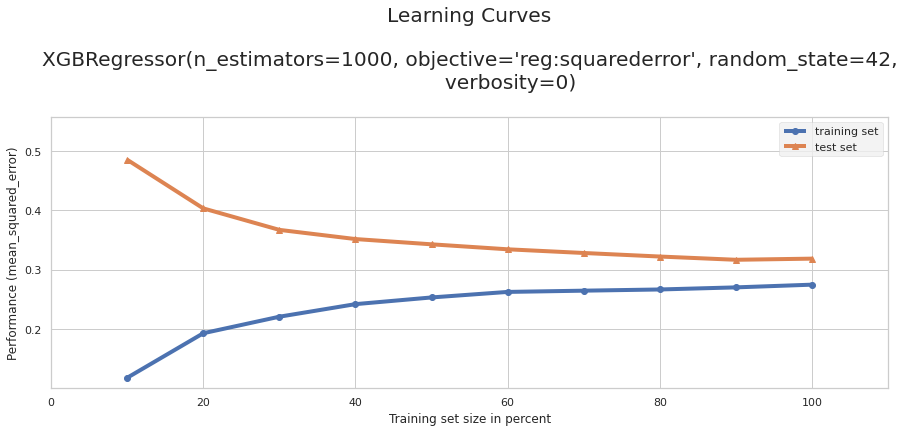

In [ ]:
# reference: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_learning_curves/
plt.subplots(figsize=(15,5))
plot_learning_curves(X_train, y_train, X_test, y_test, xgbmodel, scoring='mean_squared_error')

By analyzing both of these learning curve, we can say that model is not performing appropriately when the training data size is less than 40%. However, it started working efficiently and generating desired outcomes as training size increase and model gets trained more.

### Analyze the results

Using XGBoost algorithm, we were able to achieve around 0.48 r2_score, which is almost half to the 1. So, we can assume that predicated data and actual data is has some variance but it is very low variance. However, by
considering different approach we can build the better algorithm, which provide more good evaluation score than this baseline model and that will be our final candidate model.

#### LightGBM Regressor Candidate Model

We have used [LightGBM Regressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) for Regression, which is also an efficient implementation of gradient boosting that can be used for regression predictive modeling. As we metioned above, here we are going to use this model to predict customer_active_hours for unseen data and we considered this model as a candidate model. We have performed manually tried different hyperparameters and we have found that n_estimator=1000, boosting_type='gbdt', min_data=50 parameteres in which model is performing more efficiently. 

In [ ]:
# reference: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

lgbmmodel = LGBMRegressor(n_estimators=1000, boosting_type='gbdt', min_data=50)
lgbmmodel.fit(X_train,y_train)

LGBMRegressor(min_data=50, n_estimators=1000)

In [ ]:
y_lgbm_preds = lgbmmodel.predict(X_train)
y_lgbm_test_preds = lgbmmodel.predict(X_test)
y_lgbm_valid_preds = lgbmmodel.predict(X_valid)

In [ ]:
print("R2 Score using LGBM model on training data: ", r2_score(y_train, y_lgbm_preds))
print("R2 Score using LGBM model on testing data: ", r2_score(y_test, y_lgbm_test_preds))
print("R2 Score using LGBM model on validation data: ", r2_score(y_valid, y_lgbm_valid_preds))

R2 Score using LGBM model on training data:  0.7285381710889977
R2 Score using LGBM model on testing data:  0.505137658252007
R2 Score using LGBM model on validation data:  0.5023774176985742


#### Plot a visualization of the learning process or the learned information of the model.

A learning curve plots the optimal value of a model's loss function for a training set against this loss function evaluated on a validation data set with same parameters as produced the optimal function. We have plotted two learning curves using two different libraries such as Sklearn, and mlxtend for the candidate model as well.

In [ ]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(lgbmmodel, X_train, y_train, scoring='neg_mean_squared_error')

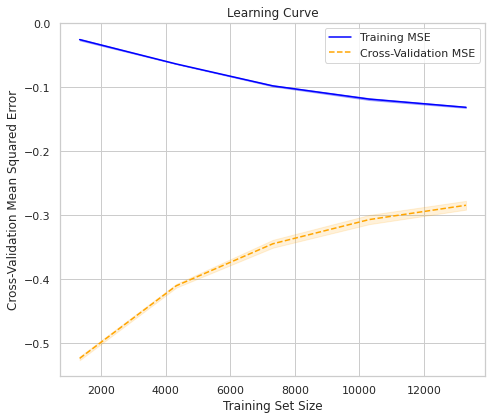

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(7,6))
plt.plot(train_sizes, train_mean, color='blue', label='Training MSE')
plt.plot(train_sizes, test_mean, color='orange', linestyle='--', label='Cross-Validation MSE')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.30, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,alpha=0.15, color='orange')

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Cross-Validation Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

([0.023806029055280287,
  0.046314074451096116,
  0.07343617725469,
  0.09263524031732,
  0.10723287470945389,
  0.11797919078029313,
  0.12455741300039017,
  0.13102446198171658,
  0.13701268843330833,
  0.1430692834203138],
 [0.5134351518852143,
  0.4353141862377419,
  0.3910918443593234,
  0.3520679340927543,
  0.3281478218378969,
  0.30772213099856005,
  0.2934765687647251,
  0.2806453532181348,
  0.27224356800502725,
  0.27077892730776776])

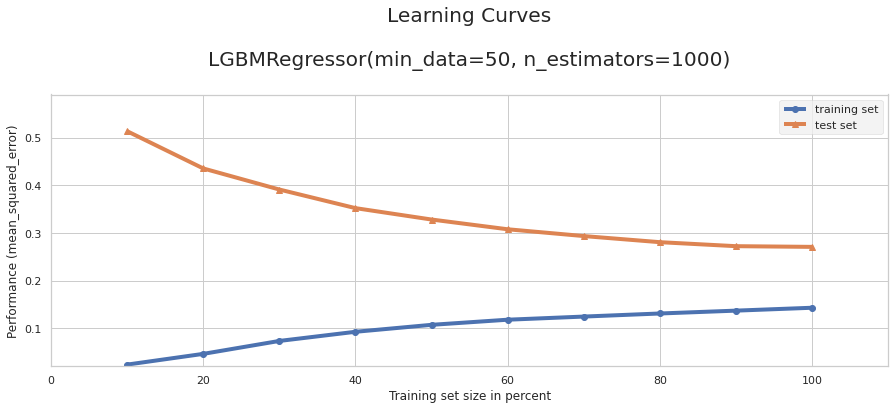

In [ ]:
plt.subplots(figsize=(15,5))
plot_learning_curves(X_train, y_train, X_test, y_test, lgbmmodel, scoring='mean_squared_error')

By analyzing both of these learning curve, we can say that model is not performing appropriately when the training data size is less than 45%. However, it started working efficiently and generating desired outcomes as training size increase and model gets trained more.

### Analyze the results

Using the LGBMRegressor algorithm, we were able to achieve 0.74 r2 score for training data, which is very close to 1, as well as 0.5 r2 score for testing and validation data. We also attempted to fit the model with L1 and L2 regularization, but found no nominal change in model accuracy. So, because regularization had no effect, we decided to use the model without it. Finally, we can assume that the variance between predicted and actual data is very low. As a result, we chose the LGBMRegressor as our final candidate model.

### Compare the baseline model and candidate model with a statistical significance test and display box plot to visualize the result.

We have used Cross Validation Score metrics to compare both (XGBoost regressor and LGBMRegressor) models. As we have performed regression technique, R2_score of the both model will be compared, and for the comparison we have plotted the box plot for both models.

To draw the box plots for both models, we first calculated the cross_validation_results for XGBoost regressor model and LGBMRegressor. Then using matplotlib library, we plotted the boxplots of both models.

#### Statistical Significance test

From the [statistical significance test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html), we have done statistical significance test on LGBMRegressor model with XGBoostRegressor Model. The null hypothesis is that we are assuming there is no stastical distribution similarity on the predictions of the models.
 
From the results, it is clearly seen that the p-value is very close to 1 (larger than 0.05), which means that we cannot reject the null hypothesis and there are no any statistical significance relationship between results of both models.

In [ ]:
stats.ttest_ind(y_lgbm_test_preds,y_test_preds)

Ttest_indResult(statistic=0.0544440816750839, pvalue=0.9565817947634334)

In [ ]:
# reference: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
model_results = []

cv_results = cross_val_score(xgbmodel,X_test, y_test)
model_results.append(cv_results)

cv_results = cross_val_score(lgbmmodel,X_test, y_test)
model_results.append(cv_results)

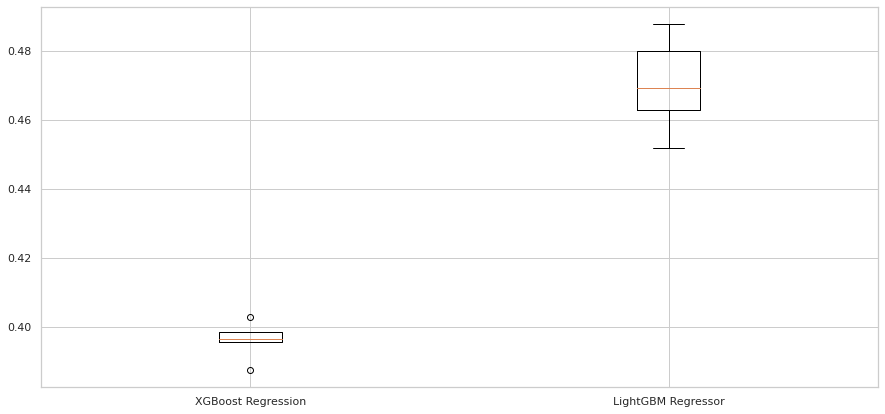

In [ ]:
plt.figure(figsize=(15,7))
plt.boxplot(model_results, labels=['XGBoost Regression', 'LightGBM Regressor'])
plt.show()

We can interpret that LightGBM Regressor model is performing more efficiently than XGBoost regressor as R2 score of LightGBM Regressor model is more than XGBoost regressor.

In [1]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('FP-Notebook-JaimiSheta-JaySonani-MitulMalani-PritSorathiya-PritThakkar.ipynb')

--2022-08-02 04:06:36--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-08-02 04:06:36 (27.8 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/FP-Notebook-JaimiSheta-JaySonani-MitulMalani-PritSorathiya-PritThakkar.ipynb to pdf
[NbConvertApp] Support files will be in FP-Notebook-JaimiSheta-JaySonani-MitulMalani-PritSorathiya-PritThakkar_files/
[NbConvertApp] Making directory ./FP-Notebook-JaimiSheta-JaySonani-MitulMalan

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'